In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

### Reading animelist.csv

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True,usecols=["user_id", "anime_id", "rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
len(rating_df)

5000000

### DATA PROCESSING

In [8]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [9]:
len(rating_df)

3246641

In [10]:
minimun_rating = min(rating_df["rating"])

In [11]:
maximun_rating = max(rating_df["rating"])

In [12]:
avg_rating = np.mean(rating_df["rating"])

In [13]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-minimun_rating)/(maximun_rating-minimun_rating)).values.astype(np.float64)

In [14]:
rating_df.duplicated().sum()

np.int64(0)

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
user_ids = rating_df["user_id"].unique().tolist()
user_encoding = {x: i for i , x in enumerate(user_ids)}
user_decoding = {i: x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user_encoding)

In [17]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [18]:
n_users = len(user_encoding)

In [19]:
n_users

4203

In [20]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime_encoding = {x: i for i , x in enumerate(anime_ids)}
anime_decoding = {i: x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime_encoding)

In [21]:
rating_df.tail()

,user_id,anime_id,rating,user,anime
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154
4999920,16507,308,0.0,4202,6584


In [22]:
n_anime = len(anime_encoding)

In [23]:
n_anime

17149

In [24]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [25]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [26]:
test_size = 1000
train_indicies = rating_df.shape[0]-test_size

In [27]:
X_train, X_test, y_train, y_test = (
    X[:train_indicies],
    X[train_indicies :],
    y[:train_indicies],
    y[train_indicies :]
)

In [28]:
X_train_array = [X_train[: , 0], X_train[:, 1]]
X_test_array = [X_test[: , 0], X_test[:, 1]]

### MODEL ARCHITECTURE

In [29]:
def RecomenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=['mae', 'mse'], optimizer='Adam')

    return model

In [30]:
model = RecomenderNet()

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [32]:
start_learn = 0.00001
min_learn = 0.00001
max_learn = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def learn_func (epoch):
    if epoch < ramup_epochs:
        return (max_learn-start_learn)/ramup_epochs*epoch + start_learn
    elif epoch < ramup_epochs+sustain_epochs:
        return max_learn
    else:
        return (max_learn-min_learn)*exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_learn

In [33]:
learn_callback = LearningRateScheduler(lambda epoch: learn_func(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [34]:
my_callbacks = [model_checkpoint, learn_callback, early_stopping]

In [35]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - loss: 0.8010 - mae: 0.3822 - mse: 0.1974 - val_loss: 0.7345 - val_mae: 0.3693 - val_mse: 0.1741 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.7974 - mae: 0.3809 - mse: 0.1960 - val_loss: 0.7936 - val_mae: 0.3813 - val_mse: 0.1949 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.7915 - mae: 0.3786 - mse: 0.1937 - val_loss: 0.7974 - val_mae: 0.3820 - val_mse: 0.1960 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.7830 - mae: 0.3754 - mse: 0.1903 - val_loss: 0.7940 - val_mae: 0.3811 - val_mse: 0.1948 - learning_rate: 3.4000e-05


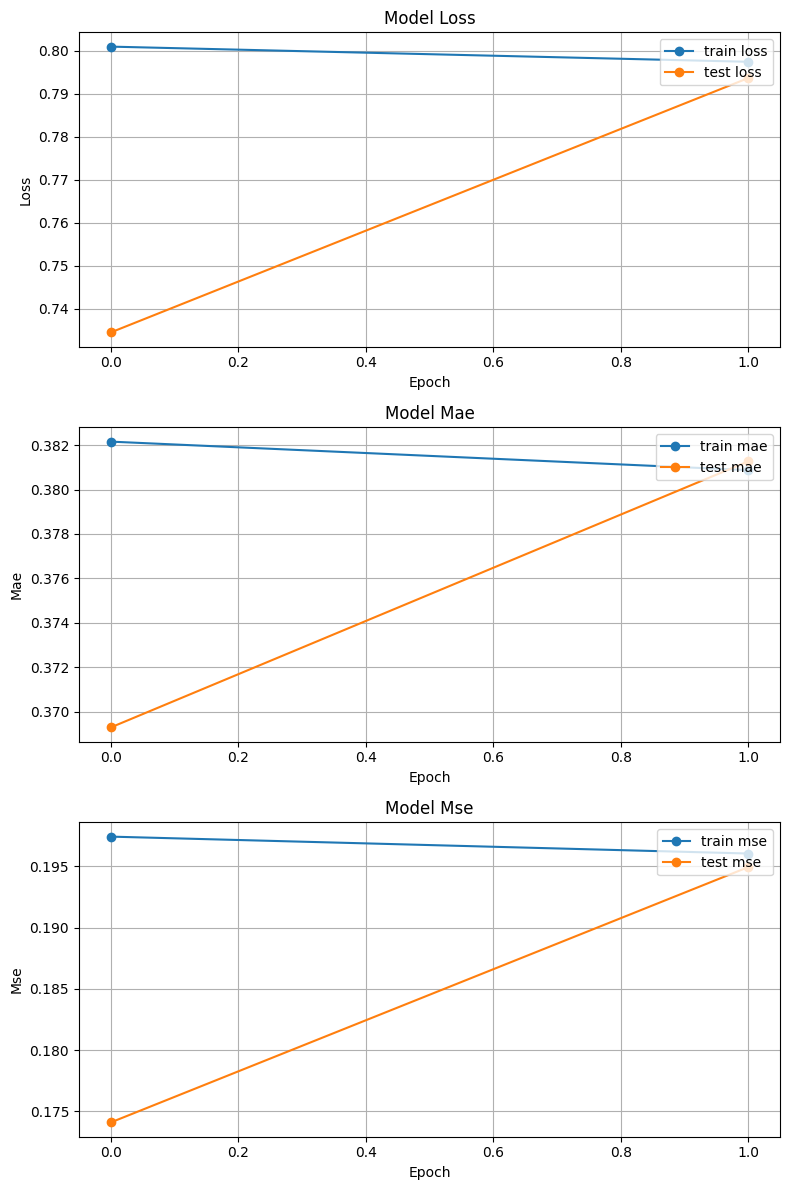

In [36]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2],marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [37]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [38]:
anime_weights = extract_weights("anime_embedding", model)

In [39]:
user_weights = extract_weights("user_embedding", model)

#### Reading anime.csv

In [40]:
df = pd.read_csv(INPUT_DIR+"/anime.csv")
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [41]:
df = df.replace("Unknown", np.nan)

In [42]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [43]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [44]:
getAnimeName(6702)

'Fairy Tail'

In [45]:
df.sort_values(by=["Score"], inplace=True, ascending=False, kind="quicksort", na_position="last")

In [46]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [47]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [48]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [49]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [50]:
def getAnimeFrame (anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [51]:
getAnimeFrame(6702,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4707,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",175,TV,Fall 2009,1312470


In [52]:
getAnimeFrame("Naruto", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",220,TV,Fall 2002,1830540


#### Reading anime_with_synopsis.csv

In [53]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [54]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [55]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [ ]:
# def getSynopsis(anime,synopsis_df):
#     if isinstance(anime, int):
#         return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
#     if isinstance(anime, str):
#         return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

def getSynopsis(anime, df):
    if isinstance(anime, int):
        row = df[df.MAL_ID == anime]
    elif isinstance(anime, str):
        row = df[df.Name == anime]
    else:
        return "Invalid anime identifier"

    if row.empty:
        return "No synopsis available"
    
    return row['sypnopsis'].values[0]


In [57]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [58]:
getSynopsis("Steins;Gate", synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

#### Content based recomendation system 

In [59]:
pd.set_option("max_colwidth", None)

In [60]:
import traceback

In [61]:
def find_similar_animes(name,anime_weights,anime_encoding,anime_decoding,df,synopsis_df, 
                        n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime_encoding.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")
        
        weights = anime_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        for x in closest:
            decoded_id = anime_decoding.get(x)
            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[x]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis" : synopsis
            })
        
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        Frame = Frame[Frame.anime_id != index]
        return Frame.drop(["anime_id"],axis=1)

    except:
        print("error occured")

In [62]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime_encoding,
    anime_decoding,
    df,
    synopsis_df,
    n=10
)

,name,similarity,genre,synopsis
9,"Sayonara, Zetsubou-Sensei",0.342213,"Comedy, Parody, School, Shounen","Nozomu Itoshiki is a high school teacher so pessimistic that even the smallest of misfortunes can send him into a pit of raging despair; some of these ""catastrophes"" even lead to suicide attempts. Sayonara Zetsubou Sensei is a satirical slice-of-life comedy set in the modern day, covering various aspects of Japanese life and culture through Nozomu and his interactions with his students: Kiri Komori, a recluse who refuses to leave the school; Abiru Kobushi, an enigma who frequently arrives to class with severe and mysterious injuries; the hyper-optimistic Kafuuka Fuura, Nozomu's polar opposite; and several other unusual girls, all of whom are just as eccentric as their teacher."
8,Free! Movie 3: Road to the World - Yume,0.306725,"Slice of Life, Comedy, Sports, Drama, School",cap of the Free!: Dive to the Future TV series featuring new scenes.
7,Teddy,0.305627,Slice of Life,short animation by Taku Furukawa.
6,Prince of Tennis:National Championship Chapter,0.302912,"Action, Comedy, Sports, Shounen","Seigaku continues their road to winning the National Championship, but only the best schools remain as they'll have to go toe-to-toe with old rivals and new foes in the National Tournament. (Source: ANN)"
5,Accel World EX,0.297918,"Action, Game, Sci-Fi, Romance, School","OVA bundled with the Accel World simulation and action games. The Blu-ray OVA discs came with the PS3 limited edition versions and the DVD with the PSP limited edition versions. The project was split into two PSP and PS3 titles, and one episode was released with each game: #EX01: Reverberation;Zankyou (bundled with Stage:01 Ginyoku no Kakusei) #EX02: Vacation;Onsen (bundled with Stage:02 Kasoku no Chouten)"
4,Pyun Pyun Maru,0.293419,"Comedy, Martial Arts",The Ninja Pyun Pyun-Maru and his brother Chibi-Maru are working at an office that accepts anything. They solve unexpected happenings caused by other Ninjas. (Source: TOEI Animation Europe catalog)
3,Onmyouji Ayakashi no Megami: Inran Jubaku,0.293055,"Hentai, Yuri",No synopsis available
2,Tales of the Abyss,0.288118,"Adventure, Drama, Fantasy","The world of Auldrant is bound by the Score, a series of prophecies from centuries past that dictate the world's future. It is considered an absolute fate that everyone lives by—even people whose actions lead to bloodshed and tears. Using magical abilities known as the Fonic Arts, a war between the nation of Kimlasca-Lanvaldear and the Malkuth Empire is waged in hopes of bringing the Score's foreseen utopia to life. Tales of the Abyss follows Luke von Fabre, who spends his days locked away in his manor after being kidnapped and losing memories as a child. One day, while honing his swordsmanship, a woman named Tear attempts to assassinate his master. Luke defends him, but the clash results in the two being teleported to a distant land. Luke and Tear’s journey back quickly escalates into a quest that will either free the world from the Score's chains or destroy it completely."
1,Pekkle in the Adventures of Sinbad,0.282474,"Adventure, Fantasy, Kids",Pekkle re-creates the Adventures of Sinbad.
0,Robot Girls Z: Fukkatsu no Chika Teikoku!? Robot Girls Z vs. Nazo no Sandai Shuyaku Robo!,0.282207,"Comedy, Parody, Mecha",Petit animation included with the Robot Girls Z Full Complete Blu-ray.


#### User based recomendation

In [63]:
def find_similar_users(input, user_weights, user_encoding, user_decoding, n=10, return_dist=False, neg=False):
    try:
        index = input
        encoded_index = user_encoding.get(index)

        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for x in closest:
            similarity = dists[x]
            if isinstance(input, int):
                decoded_id = user_decoding.get(x)
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != input]
        return similar_users
    
    except Exception as e:
        print("Error occured", e)
        

In [64]:
find_similar_users(15019, user_weights, user_encoding, user_decoding)

,similar_users,similarity
9,7818,0.339883
8,7450,0.293603
7,9979,0.274703
6,6359,0.260252
5,10344,0.252666
4,15958,0.250359
3,301,0.245459
2,13909,0.242296
1,6321,0.241719
0,8949,0.238778


In [65]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [66]:
from collections import defaultdict

In [67]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    if plot:
        showWordCloud(all_genres)
    return genres_list

In [68]:
def get_user_preferences(user_id, rating_df, df, verbose=0, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    user_rating_precentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_precentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows

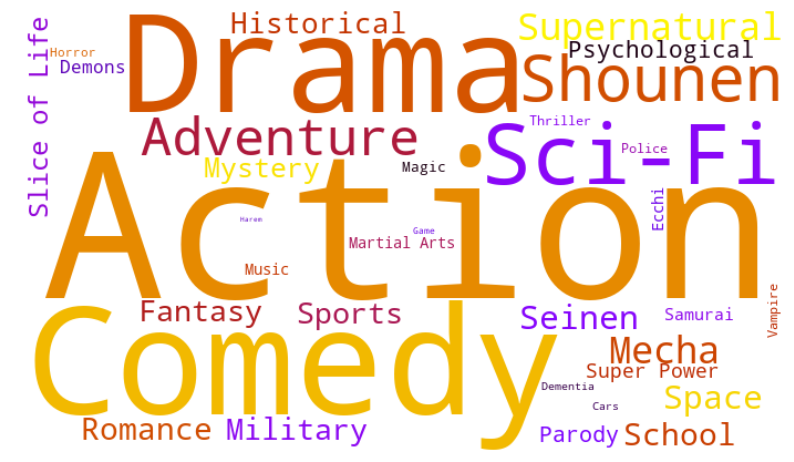

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [69]:
get_user_preferences(11880, rating_df, df,plot=True)

In [70]:
find_similar_users(15019, user_weights, user_encoding, user_decoding)

,similar_users,similarity
9,7818,0.339883
8,7450,0.293603
7,9979,0.274703
6,6359,0.260252
5,10344,0.252666
4,15958,0.250359
3,301,0.245459
2,13909,0.242296
1,6321,0.241719
0,8949,0.238778


In [71]:
def get_user_recomendations(similar_users, user_preferences, df, synopsis_df, rating_df, n=10):
    recommndations = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        pref_list = pref_list[pref_list.eng_version.isin(user_preferences.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
    
    if anime_list:
        anime_list = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)

                recommndations.append({
                    "n" : n_user_pref,
                    "anime_name": anime_name,
                    "Genre" : genre,
                    "Synopsis" : synopsis
                })
    
    return pd.DataFrame(recommndations).head(n)

In [72]:
similar_users = find_similar_users(11880, user_weights, user_encoding, user_decoding)

In [73]:
user_pref = get_user_preferences(11880, rating_df, df)

In [74]:
get_user_recomendations(similar_users, user_pref, df, synopsis_df, rating_df)

,n,anime_name,Genre,Synopsis
0,18,Bakuman.,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
1,7,Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi","Simon and Kamina were born and raised in a deep, underground village, hidden from the fabled surface. Kamina is a free-spirited loose cannon bent on making a name for himself, while Simon is a timid young boy with no real aspirations. One day while excavating the earth, Simon stumbles upon a mysterious object that turns out to be the ignition key to an ancient artifact of war, which the duo dubs Lagann. Using their new weapon, Simon and Kamina fend off a surprise attack from the surface with the help of Yoko Littner, a hot-blooded redhead wielding a massive gun who wanders the world above. In the aftermath of the battle, the sky is now in plain view, prompting Simon and Kamina to set off on a journey alongside Yoko to explore the wastelands of the surface. Soon, they join the fight against the ""Beastmen,"" humanoid creatures that terrorize the remnants of humanity in powerful robots called ""Gunmen."" Although they face some challenges and setbacks, the trio bravely fights these new enemies alongside other survivors to reclaim the surface, while slowly unraveling a galaxy-sized mystery."
2,7,Bakemonogatari,"Romance, Supernatural, Mystery, Vampire","Koyomi Araragi, a third-year high school student, manages to survive a vampire attack with the help of Meme Oshino, a strange man residing in an abandoned building. Though being saved from vampirism and now a human again, several side effects such as superhuman healing abilities and enhanced vision still remain. Regardless, Araragi tries to live the life of a normal student, with the help of his friend and the class president, Tsubasa Hanekawa. When fellow classmate Hitagi Senjougahara falls down the stairs and is caught by Araragi, the boy realizes that the girl is unnaturally weightless. Despite Senjougahara's protests, Araragi insists he help her, deciding to enlist the aid of Oshino, the very man who had once helped him with his own predicament. Through several tales involving demons and gods, Bakemonogatari follows Araragi as he attempts to help those who suffer from supernatural maladies."
3,6,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenan

#### Hybrid recommendation system

In [75]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user_encoding,user_decoding)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recomendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime_encoding, anime_decoding, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

In [76]:
hybrid_recommendation(11880)

['Bakuman.', 'Gurren Lagann', 'Bakemonogatari', 'Fullmetal Alchemist:Brotherhood', 'Monogatari Series:Second Season', 'My Hero Academia', 'Durarara!!', 'One Punch Man', 'Nekomonogatari Black', 'My Hero Academia 2']


['Bio Hunter',
 'Bakuman.',
 'Gurren Lagann',
 'Bakemonogatari',
 'Fullmetal Alchemist:Brotherhood',
 'Monogatari Series:Second Season',
 'My Hero Academia',
 'Durarara!!',
 'One Punch Man',
 'Nekomonogatari Black']